In [54]:
import pandas as pd
import time
import sys
import os
import re

fecha = "18-11-2022"
dia = fecha.split("-")[0]
mes = fecha.split("-")[1]
anyo = fecha.split("-")[2]

nombre_target = f"../csv/eduroam/Eduroam_{dia}{mes}{anyo}.csv"

datos_edu = pd.read_csv(nombre_target, sep=',',on_bad_lines="skip")

datos_pc = pd.read_csv(f"../csv/off/csv_offline_filter/pcount_filter_{anyo}-{mes}-{dia}.csv", sep=';',on_bad_lines="skip")


In [55]:
def arreglarMAC(oidObject):
    oidObject = oidObject[-14:-2]
    return oidObject[0:2] + ':' + oidObject[2:4] + ':' + oidObject[4:6] + ':' + oidObject[6:8] + ':' + oidObject[8:10] + ':' + oidObject[10:12] 


def arreglo_df_Wifi_A(dataframe_Wifi_A):

    # Creación de la lista de IP de APs que nos interesan
    lista_nombre_APs = ['ANT-PB-N-O-Biblio', 'ANT-PB-N-C-Biblio', 'ANT-PB-N-E-Biblio', 'ANT-PB-E-NN-Biblio', 'ANT-PB-E-N-Biblio', 'ANT-PB-E-S-Biblio', 'ANT-PB-E-SS-Biblio']
    lista_IPs_APs = ['192.168.89.189', '192.168.89.187', '192.168.89.111', '192.168.89.184', '192.168.89.181', '192.168.89.182', '192.168.89.249']
    lista_IPs_APs = dict(zip(lista_nombre_APs, lista_IPs_APs))

    lista_completa_APs = lista_IPs_APs
    lista_completa_APs = pd.Series(lista_completa_APs)

    dataframe_Wifi_A = dataframe_Wifi_A.copy()
    dataframe_Wifi_A.columns = ['Nº Secuencia', 'Fecha_Hora', 'MAC','MACWLAN', 'IP', 'IPAP', 'Nombre', 'sistema operativo', 'relacion SN', 'TXDataFr', 'TXDataBy', 'TXRetries', 'TXRate', 'RXDataFr', 'RXDataBy', 'RXRetries', 'RXRate']
    dataframe_Wifi_A.drop_duplicates(inplace=True)
    dataframe_Wifi_A = dataframe_Wifi_A[(dataframe_Wifi_A['MAC'] != '0') & (dataframe_Wifi_A['MAC'].notna()) & (dataframe_Wifi_A['MACWLAN'].notna()) & (dataframe_Wifi_A['IP'].notna()) & (dataframe_Wifi_A['IPAP'].notna())]

    # Código propio para arreglar las columnas de MACs e IPs respecto a la nomenclatura SNMP.
    dataframe_Wifi_A['MAC'] = [arreglarMAC(oid) for oid in dataframe_Wifi_A['MAC']]
    dataframe_Wifi_A['MACWLAN'] = [arreglarMAC(oid) for oid in dataframe_Wifi_A['MACWLAN']]

    # Código TFM, mediante expresiones regulares, para arreglar MACs e IPs respecto nomenclatura SNMP
    dataframe_Wifi_A['IP'] = dataframe_Wifi_A['IP'].str.extract(r" ([\d\.]+)']$")
    dataframe_Wifi_A['IPAP'] = dataframe_Wifi_A['IPAP'].str.extract(r" ([\d\.]+)']$")

    # Algunas MACs están corruptas, por lo que aplicamos esta expresión regular para filtrarlas
    # Fuente: https://stackoverflow.com/questions/7629643/how-do-i-validate-the-format-of-a-mac-address
    dataframe_Wifi_A['MAC'] = dataframe_Wifi_A['MAC'].apply(lambda x: x if re.match("[0-9a-f]{2}([-:]?)[0-9a-f]{2}(\\1[0-9a-f]{2}){4}$", x.lower()) else 0)
    dataframe_Wifi_A = dataframe_Wifi_A[dataframe_Wifi_A['MAC'] != 0]

    dataframe_Wifi_A = dataframe_Wifi_A[dataframe_Wifi_A['IPAP'].isin(lista_completa_APs)]
    dataframe_Wifi_A = dataframe_Wifi_A[~dataframe_Wifi_A["IP"].str.contains("192.168.102.")]

    return  dataframe_Wifi_A

In [56]:
datos_edu = arreglo_df_Wifi_A(datos_edu)
datos_edu.to_csv("../csv/eduroam/2022-11-08_eduroam.csv",index=False)

In [57]:
ts = datos_edu["Fecha_Hora"].drop_duplicates()
ts

33        2022-11-14 07:00:02
69        2022-11-14 07:03:02
105       2022-11-14 07:06:02
140       2022-11-14 07:09:01
175       2022-11-14 07:12:01
                 ...         
177996    2022-11-14 22:42:22
178033    2022-11-14 22:45:02
178068    2022-11-14 22:51:02
178104    2022-11-14 22:54:01
178139    2022-11-14 22:57:02
Name: Fecha_Hora, Length: 289, dtype: object

In [58]:
datos_edu[datos_edu["Fecha_Hora"].str.contains("2022-11-08 08:00")].drop_duplicates(["MAC"])

,Nº Secuencia,Fecha_Hora,MAC,MACWLAN,IP,IPAP,Nombre,sistema operativo,relacion SN,TXDataFr,TXDataBy,TXRetries,TXRate,RXDataFr,RXDataBy,RXRetries,RXRate


In [59]:
def get_datagraph(df):
    times=[]
    cuentas=[]
    for i in ts:
        pcnt = len(df[df['Fecha_Hora']==i]['MAC'].drop_duplicates())
        times.append(i)
        cuentas.append(pcnt)

    r = pd.DataFrame(columns=['Timestamp','Ocupacion'])
    r['Timestamp'] = times
    r['Ocupacion'] = cuentas
    r['Timestamp'] = pd.to_datetime(r['Timestamp'], dayfirst=True)
    return r

In [60]:
datos_edu_A = datos_edu[datos_edu['IPAP'].isin(["192.168.89.182","192.168.89.249"])]
datos_edu_B = datos_edu[datos_edu['IPAP'].isin(["192.168.89.184","192.168.89.181"])]
datos_edu_CDE = datos_edu[datos_edu['IPAP'].isin(["192.168.89.111","192.168.89.187","192.168.89.189"])]


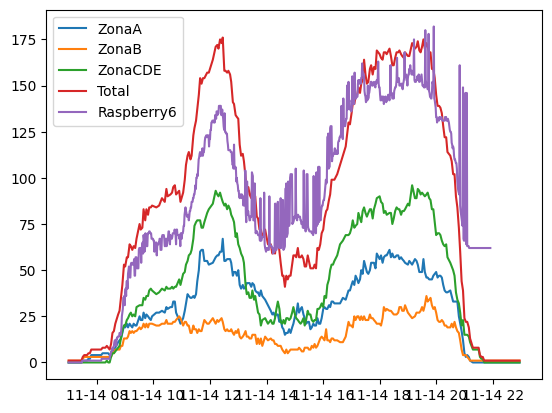

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

datos_pc['Timestamp'] = datos_pc['Fecha'] + " " + datos_pc['Hora']
datos_pc['Timestamp'] = pd.to_datetime(datos_pc['Timestamp'], dayfirst=True)
datos_edu['Fecha_Hora'] = pd.to_datetime(datos_edu['Fecha_Hora'], dayfirst=True)

datos_edu_A = datos_edu[datos_edu['IPAP'].isin(["192.168.89.182","192.168.89.249"])]
datos_edu_B = datos_edu[datos_edu['IPAP'].isin(["192.168.89.184","192.168.89.181"])]
datos_edu_CDE = datos_edu[datos_edu['IPAP'].isin(["192.168.89.111","192.168.89.187","192.168.89.189"])]


datos_edu_A = get_datagraph(datos_edu_A)
ax.plot(datos_edu_A['Timestamp'],datos_edu_A['Ocupacion'])

datos_edu_B = get_datagraph(datos_edu_B)
ax.plot(datos_edu_B['Timestamp'],datos_edu_B['Ocupacion'])

datos_edu_CDE = get_datagraph(datos_edu_CDE)
ax.plot(datos_edu_CDE['Timestamp'],datos_edu_CDE['Ocupacion'])

datos_edu = get_datagraph(datos_edu)
ax.plot(datos_edu['Timestamp'],datos_edu['Ocupacion'])


ax.plot(datos_pc['Timestamp'],datos_pc['Ocupacion'])


ax.legend(['ZonaA','ZonaB','ZonaCDE','Total','Raspberry6'])

plt.savefig(f"../csv/graphs/{anyo}-{mes}-{dia}_PC-Edu.jpg")

In [62]:
datos_edu_A['Timestamp']

0     2022-11-14 07:00:02
1     2022-11-14 07:03:02
2     2022-11-14 07:06:02
3     2022-11-14 07:09:01
4     2022-11-14 07:12:01
              ...        
284   2022-11-14 22:42:22
285   2022-11-14 22:45:02
286   2022-11-14 22:51:02
287   2022-11-14 22:54:01
288   2022-11-14 22:57:02
Name: Timestamp, Length: 289, dtype: datetime64[ns]